In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [3]:
!pip install torch==1.5.0  torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html



Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 30kB/s 
     |████████████████████████████████| 6.5MB 56.9MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [12]:
import torch
from torch import nn, optim, as_tensor
import torchvision
import torch.nn as nn  
import torch.nn.functional as F
from torch.autograd import grad

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys
import glob
from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

from torch.autograd import Variable

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.5.0+cu92
0.6.0+cu92


In [3]:
ZDIMS = 100
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        # 28 x 28 pixels = 784 input pixels, 400 outputs
        self.fc1 = nn.Linear(4096, 2000)
        # rectified linear unit layer from 400 to 400
        # max(0, x)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(2000, ZDIMS)  # mu layer
        self.fc22 = nn.Linear(2000, ZDIMS)  # logvariance layer
        # this last layer bottlenecks through ZDIMS connections

        # DECODER
        # from bottleneck to hidden 400
        self.fc3 = nn.Linear(ZDIMS, 2000)
        # from hidden 400 to 784 outputs
        self.fc4 = nn.Linear(2000, 4096)
        # self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def encode(self, x: Variable) -> (Variable, Variable):
        """Input vector x -> fully connected 1 -> ReLU -> (fully connected
        21, fully connected 22)

        Parameters
        ----------
        x : [128, 784] matrix; 128 digits of 28x28 pixels each

        Returns
        -------

        (mu, logvar) : ZDIMS mean units one for each latent dimension, ZDIMS
            variance units one for each latent dimension

        """

        # h1 is [128, 400]
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        """THE REPARAMETERIZATION IDEA:

        For each training sample (we get 128 batched at a time)

        - take the current learned mu, stddev for each of the ZDIMS
          dimensions and draw a random sample from that distribution
        - the whole network is trained so that these randomly drawn
          samples decode to output that looks like the input
        - which will mean that the std, mu will be learned
          *distributions* that correctly encode the inputs
        - due to the additional KLD term (see loss_function() below)
          the distribution will tend to unit Gaussians

        Parameters
        ----------
        mu : [128, ZDIMS] mean matrix
        logvar : [128, ZDIMS] variance matrix

        Returns
        -------

        During training random sample from the learned ZDIMS-dimensional
        normal distribution; during inference its mean.

        """

        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation
            std = logvar.mul(0.5).exp_()  # type: Variable
            # - std.data is the [128,ZDIMS] tensor that is wrapped by std
            # - so eps is [128,ZDIMS] with all elements drawn from a mean 0
            #   and stddev 1 normal distribution that is 128 samples
            #   of random ZDIMS-float vectors
            eps = Variable(std.data.new(std.size()).normal_())
            # - sample from a normal distribution with standard
            #   deviation = std and mean = mu by multiplying mean 0
            #   stddev 1 sample with desired std and mu, see
            #   https://stats.stackexchange.com/a/16338
            # - so we have 128 sets (the batch) of random ZDIMS-float
            #   vectors sampled from normal distribution with learned
            #   std and mu for the current input
            return eps.mul(std).add_(mu)

        else:
            # During inference, we simply spit out the mean of the
            # learned distribution for the current input.  We could
            # use a random sample from the distribution, but mu of
            # course has the highest probability.
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        # return self.sigmoid(self.fc4(h3))
        return self.tanh(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 4096))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar





def loss_function(recon_x, x, mu, logvar) :
    # how well do input x and output recon_x agree?
    # BCE = F.binary_cross_entropy(recon_x, x.view(-1, 4096))
    MSE = F.mse_loss(recon_x, x.view(-1, 4096))


    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 4096

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    # return BCE + KLD
    return MSE + KLD



In [4]:
transform = transforms.Compose(
[transforms.Resize((64,64)),
        transforms.ToTensor()])
       


In [5]:
dataset= datasets.ImageFolder(root="/content/drive/My Drive/Colab Notebooks/EVA_P2/S6",transform=transform)


In [6]:
dataset

Dataset ImageFolder
    Number of datapoints: 347
    Root location: /content/drive/My Drive/Colab Notebooks/EVA_P2/S6
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [7]:
train_set, test_set = torch.utils.data.random_split(dataset, [300, 47])

**Loading data to train and test loader**

In [8]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(111)

if cuda:
    torch.cuda.manual_seed(111)

    trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True,num_workers=4)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True,num_workers=4)



CUDA Available? True


<Figure size 432x288 with 0 Axes>

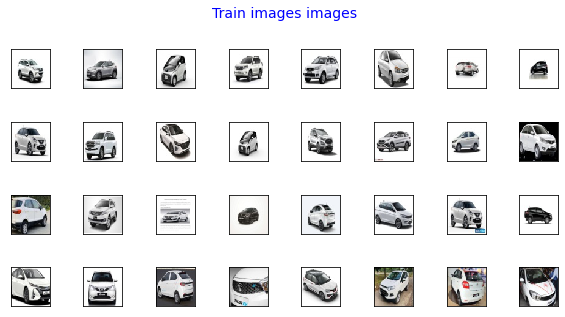

In [35]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import PIL.Image as Image

fig = plt.figure()
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Train images images' ,y=1.05,fontsize=14,color='b')

dataiter = iter(trainloader)
images, labels = dataiter.next()


for i in range(32):
  plt.subplot(8,8,i+1)
  plt.tight_layout()
  plt.imshow(((images[i]).permute(1,2,0).numpy().squeeze()), interpolation='none')
  # plt.title('A: {}\n'.format(classes[labels[126]]))

  plt.xticks([])
  plt.yticks([])


In [9]:
model=VAE()

In [10]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)
summary(model,input_size=(3,64,64))
print("Model added to device")

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2000]       8,194,000
              ReLU-2                 [-1, 2000]               0
            Linear-3                  [-1, 100]         200,100
            Linear-4                  [-1, 100]         200,100
            Linear-5                 [-1, 2000]         202,000
              ReLU-6                 [-1, 2000]               0
            Linear-7                 [-1, 4096]       8,196,096
              Tanh-8                 [-1, 4096]               0
Total params: 16,992,296
Trainable params: 16,992,296
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.13
Params size (MB): 64.82
Estimated Total Size (MB): 64.99
----------------------------------------------------------------
Model added to device


In [13]:
LOG_INTERVAL = 10


# connections through the autoencoder bottleneck
# in the pytorch VAE example, this is 20
BATCH_SIZE=32
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [14]:

def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(trainloader):
        data=Variable(data).to(device)
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.data.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.8f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss.data.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.8f}'.format(
          epoch, train_loss / len(trainloader.dataset)))


def test(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(testloader):
        # if CUDA:
            # make sure this lives on the GPU
        data = data.to(device)

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
          n = min(data.size(0), 8)
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
          comparison = torch.cat([data[:n],
                                  recon_batch.view(BATCH_SIZE, 1, 64, 64)[:n]])
          save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))



In [24]:
EPOCHS = 2000

In [25]:

for epoch in range(1, EPOCHS + 1):
    train(epoch)
    # test(epoch)

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    if epoch==EPOCHS:
      sample = Variable(torch.randn(64, ZDIMS))
      sample= sample.to(device)
      sample = model.decode(sample).cpu()

      # save out as an 8x8 matrix of MNIST digits
      # this will give you a visual idea of how well latent space can generate things
      # that look like digits
      
      save_image(sample.data.view(64, 1, 64, 64),
                "/content/drive/My Drive/Colab Notebooks/EVA_P2/S7/Sample" + str(epoch) + '.jpg')

Train Epoch: 1 [0/300 (0%)]	Loss: 0.02034373
====> Epoch: 1 Average loss: 0.00829952
Train Epoch: 2 [0/300 (0%)]	Loss: 0.00331806
====> Epoch: 2 Average loss: 0.00356869
Train Epoch: 3 [0/300 (0%)]	Loss: 0.00279666
====> Epoch: 3 Average loss: 0.00297034
Train Epoch: 4 [0/300 (0%)]	Loss: 0.00260204
====> Epoch: 4 Average loss: 0.00268382
Train Epoch: 5 [0/300 (0%)]	Loss: 0.00228532
====> Epoch: 5 Average loss: 0.00249727
Train Epoch: 6 [0/300 (0%)]	Loss: 0.00233355
====> Epoch: 6 Average loss: 0.00244275
Train Epoch: 7 [0/300 (0%)]	Loss: 0.00219470
====> Epoch: 7 Average loss: 0.00243042
Train Epoch: 8 [0/300 (0%)]	Loss: 0.00224249
====> Epoch: 8 Average loss: 0.00237372
Train Epoch: 9 [0/300 (0%)]	Loss: 0.00226369
====> Epoch: 9 Average loss: 0.00238932
Train Epoch: 10 [0/300 (0%)]	Loss: 0.00227086
====> Epoch: 10 Average loss: 0.00233370
Train Epoch: 11 [0/300 (0%)]	Loss: 0.00232877
====> Epoch: 11 Average loss: 0.00231670
Train Epoch: 12 [0/300 (0%)]	Loss: 0.00217664
====> Epoch: 12

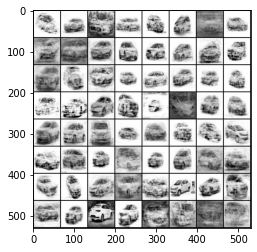

In [26]:
import cv2
img =cv2.imread("/content/drive/My Drive/Colab Notebooks/EVA_P2/S7/Sample2000.jpg")

plt.imshow(img)